Opsmate has a handful of [built-in](/cookbooks/automation-using-python-runtime/#built-in-tools) tools you can use out of the box, however there are always customisations and extensions you want to build for your own use cases.

Opsmate comes with a plugin system to allow you to build your own tools and use them in your automation.

In this cookbook we will show you how to write and author your own plugins and use it in your automation via writing a Prometheus query plugin.



## Prerequisites

* You have a OpenAI API key, otherwise Anthropic API key is also supported, as Opsmate is LLM provider agnostic.
* You have Opsmate installed - see [getting started](/#getting-started) for more details.
* You have [kind](https://kind.sigs.k8s.io/docs/user/quick-start/#installation) installed, as Opsmate uses kind to run local Kubernetes cluster.
* You have [kubectl](https://kubernetes.io/docs/tasks/tools/#kubectl) installed for interacting with the local Kubernetes cluster.

## Setup

First, let's install our required packages and set our API keys.

In [73]:
import getpass
import os


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


_set_if_undefined("OPENAI_API_KEY") # Feel to comment this out and use Anthropic API key instead
_set_if_undefined("ANTHROPIC_API_KEY")


Then we will spin up a local k8s cluster and install the [Prometheus Operator](https://github.com/prometheus-operator/prometheus-operator) onto the local cluster.

In [4]:
! kind create cluster --name opsmate-plugin-test

Creating cluster "opsmate-plugin-test" ...
 ✓ Ensuring node image (kindest/node:v1.31.2) 🖼
 ✓ Preparing nodes 📦 7l
 ✓ Writing configuration 📜7l
 ✓ Starting control-plane 🕹️7l
 ✓ Installing CNI 🔌7l
 ✓ Installing StorageClass 💾7l
Set kubectl context to "kind-opsmate-plugin-test"
You can now use your cluster with:

kubectl cluster-info --context kind-opsmate-plugin-test

Thanks for using kind! 😊


In [74]:
# make sure that you are running on the correct cluster
! kubectl config current-context

kind-opsmate-plugin-test


Now we will install the LGTM stack on the cluster.

In [30]:
%%capture # to hide the output
%%bash
(
  rm -rf /tmp/kube-prometheus
  git clone https://github.com/prometheus-operator/kube-prometheus  --depth 1 /tmp/kube-prometheus
  cd /tmp/kube-prometheus
  kubectl apply --server-side -f manifests/setup
  kubectl wait \
    --for condition=Established \
    --all CustomResourceDefinition \
    --namespace=monitoring
  kubectl apply -f manifests/
)

The prometheus server is running on :9090 against the cluster local IP address thus likely unavailable in the host space. To make it available you can run

```bash
kubectl --namespace monitoring port-forward svc/prometheus-k8s 9090
```

## Our First Plugin

The `./plugins/prom.py` file contains the plugin we wrote for this cookbook. The job it tries to accomplish is reasonably complex:

* It extracts the datetime range from the user's query
* It queries the Prometheus API to get the metrics within the time range
* It returns the metrics to a string and represent it as a markdown table



In [75]:
! cat ./plugins/prom.py

from opsmate.dino.types import ToolCall, PresentationMixin
from pydantic import Field, PrivateAttr
from typing import ClassVar, Optional
from httpx import AsyncClient
from opsmate.dino import dino
from opsmate.dino.types import Message
from opsmate.tools.datetime import DatetimeRange, datetime_extraction
from opsmate.plugins import auto_discover
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


class PromQuery(ToolCall, DatetimeRange, PresentationMixin):
    """
    A tool to query metrics from Prometheus
    """

    endpoint: ClassVar[str] = "http://localhost:9090"
    path: ClassVar[str] = "/api/v1/query_range"

    query: str = Field(description="The prometheus query")
    step: str = Field(
        description="Query resolution step width in duration format or float number of seconds",
        default="15s",
    )
    output: Optional[dict] = Field(
        description="The output of the prometheus query - DO NOT USE THIS FIELD",
        default=N

## Discovering plugins

In the plugin code if you have a keen eye you probably have already noticed the `@auto_discover` decorator. This is the key to discover the plugin.

By default all the tools are discovered automatically, but for LLM functions you will need to explicitly mark it as discoverable via the `@auto_discover` decorator.

To make the plugin discovered from where-ever your current python path is, you can execute the discovery via the following snippet:

In [64]:
from opsmate.plugins import PluginRegistry as plugins

plugins.clear()
plugins.discover("./plugins", ignore_conflicts=True)


2025-01-14 21:04:57 [debug    ] loading builtin tools         
2025-01-14 21:04:57 [debug    ] loading builtin tools from     builtin_module=opsmate.tools
2025-01-14 21:04:57 [debug    ] loading dtool                  dtool=FileAppend
2025-01-14 21:04:57 [debug    ] loading dtool                  dtool=FileDelete
2025-01-14 21:04:57 [debug    ] loading dtool                  dtool=FileRead
2025-01-14 21:04:57 [debug    ] loading dtool                  dtool=FileWrite
2025-01-14 21:04:57 [debug    ] loading dtool                  dtool=FilesFind
2025-01-14 21:04:57 [debug    ] loading dtool                  dtool=FilesList
2025-01-14 21:04:57 [debug    ] loading dtool                  dtool=HttpCall
2025-01-14 21:04:57 [debug    ] loading dtool                  dtool=HttpGet
2025-01-14 21:04:57 [debug    ] loading dtool                  dtool=HttpToText
2025-01-14 21:04:57 [debug    ] loading dtool                  dtool=KnowledgeRetrieval
2025-01-14 21:04:57 [debug    ] loading dtool  

With the prometheus_query plugin discovered, we can now use it to query the Prometheus API.

In [67]:
prom_query_builder = plugins.get_plugin("prometheus_query")

# make sure the plugin is discovered
assert prom_query_builder is not None

# execute the plugin to build a query
query = await prom_query_builder.execute("number of pods within the cluster over the last 10 minutes")

print(query)


/home/jingkaihe/workspace/opsmate/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


start='2025-01-14T20:57:14Z' end='2025-01-14T21:07:14Z' query='count(kube_pod_info)' step='15s' output=None y_label='Number of Pods' x_label='Timestamp' title='Number of Pods in the Cluster over Time'


As you have already seen The query builder is capable of figuring out the time range from the query, which is very much the Achilles heel of the LLM. In the specific example the query builder is able to figure out the time range from `over the last 10 minutes` via the `datetime_extraction` tool, which is part of the built-in tools.

Now with the query built from the query builder, we can now execute the query to get the result.

The custom method `time_series()` is a method that is defined in the plugin class to plot the time series data.

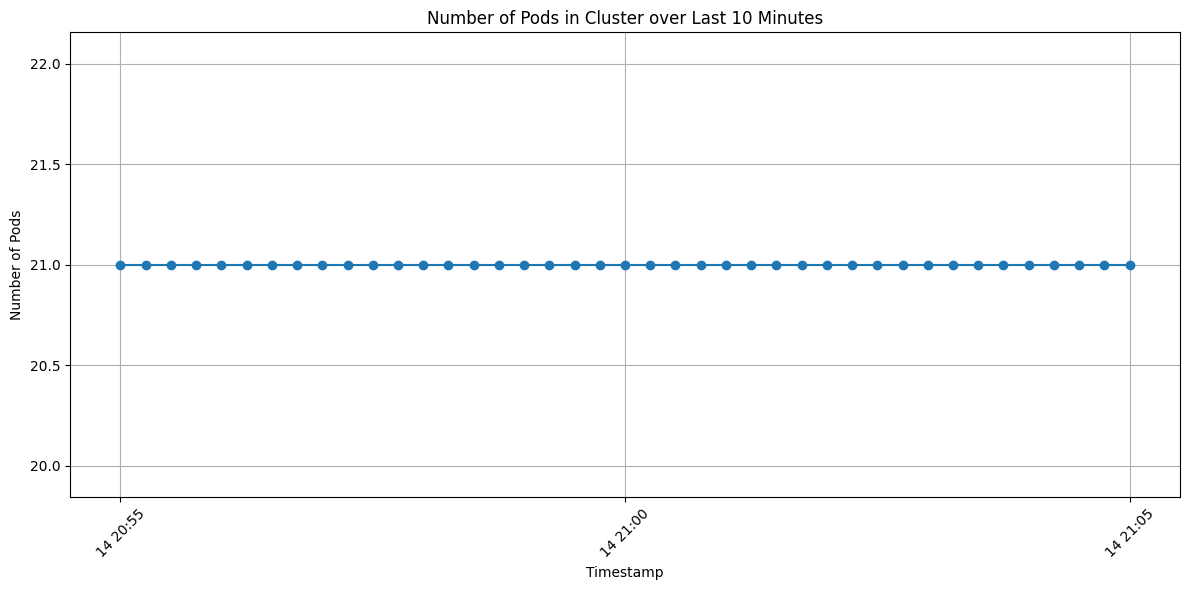

In [66]:
await query.run()

query.time_series()


Here we will create an async function that wraps up the above procedure.

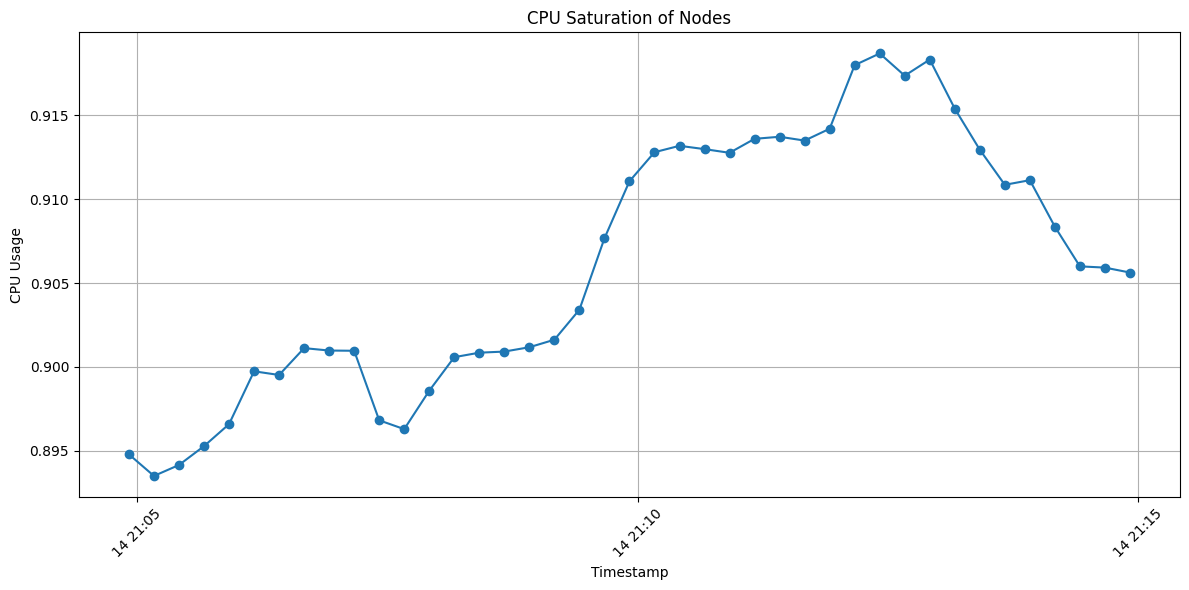

In [72]:
async def text_to_time_series(query: str):
    query = await prom_query_builder.execute(query)
    await query.run()
    query.time_series()

await text_to_time_series("CPU saturation of the nodes between 20 mins ago to 10 mins ago")
